In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


from arch import arch_model
from sklearn.metrics import mean_absolute_error


df = pd.read_csv("/Users/kartik/github/cryptocurrency_market_analysis/merged_crypto_2023_2024.csv", parse_dates=["time"])
df.head()

,time,coin,open,high,low,close,volumefrom,volumeto
0,2023-01-01,sol,9.952,10.08,9.700,9.99,3717429.17,3.664710e+07
1,2023-01-02,sol,9.990,11.97,9.791,11.28,6930407.48,7.628264e+07
2,2023-01-03,sol,11.280,13.80,11.010,13.39,10274568.45,1.290216e+08
3,2023-01-04,sol,13.390,14.22,12.820,13.44,10543054.16,1.428243e+08
4,2023-01-05,sol,13.440,13.86,12.950,13.43,4946914.33,6.588539e+07


In [2]:
df['target'] = (df.groupby('coin')['close'].shift(-1) > df['close']).astype(int)
df['coin_code'] = df['coin'].astype('category').cat.codes

# One-hot encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
coin_encoded = encoder.fit_transform(df[['coin']])
coin_df = pd.DataFrame(coin_encoded, columns=encoder.get_feature_names_out(['coin']))

# Add to main dataframe
df = pd.concat([df, coin_df], axis=1)


In [3]:
df.columns

Index(['time', 'coin', 'open', 'high', 'low', 'close', 'volumefrom',
       'volumeto', 'target', 'coin_code', 'coin_ada', 'coin_bnb', 'coin_btc',
       'coin_doge', 'coin_eth', 'coin_sol', 'coin_trx', 'coin_usdc',
       'coin_usdt', 'coin_xrp'],
      dtype='object')

In [4]:
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volume import VolumeWeightedAveragePrice

#Calculate RSI properly for each coin
def calculate_rsi(group):
    rsi = RSIIndicator(close=group['close'], window=14)
    return rsi.rsi()

df['rsi_14'] = df.groupby('coin', group_keys=False).apply(calculate_rsi)

In [5]:
def calculate_technical_indicators(group):
    # MACD
    macd = MACD(close=group['close'])
    group['macd_line'] = macd.macd()
    group['macd_signal'] = macd.macd_signal()
    
    # Bollinger Bands
    bb = BollingerBands(close=group['close'])
    group['bb_upper'] = bb.bollinger_hband()
    group['bb_middle'] = bb.bollinger_mavg()
    group['bb_lower'] = bb.bollinger_lband()
    
    # Volume Weighted Average Price
    vwap = VolumeWeightedAveragePrice(
        high=group['high'],
        low=group['low'],
        close=group['close'],
        volume=group['volumeto'],
        window=14
    )
    group['vwap'] = vwap.volume_weighted_average_price()
    
    return group

df = df.groupby('coin', group_keys=False).apply(calculate_technical_indicators)


In [6]:
def create_lagged_features(group):
    # Daily returns
    group['daily_return'] = group['close'].pct_change()
    
    # Lagged returns
    for lag in [1, 3, 7]:
        group[f'return_lag_{lag}'] = group['daily_return'].shift(lag)
    
    # Volume features
    group['volume_ma_7'] = group['volumeto'].rolling(7).mean()
    group['volume_zscore'] = (group['volumeto'] - group['volume_ma_7']) / group['volumeto'].std()
    
    return group

df = df.groupby('coin', group_keys=False).apply(create_lagged_features)


In [7]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['daily_return'] = df.groupby('coin')['close'].pct_change()
df.head()

,coin,open,high,low,close,volumefrom,volumeto,target,coin_code,coin_ada,...,bb_upper,bb_middle,bb_lower,vwap,daily_return,return_lag_1,return_lag_3,return_lag_7,volume_ma_7,volume_zscore
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01,sol,9.952,10.08,9.700,9.99,3717429.17,3.664710e+07,1,5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,sol,9.990,11.97,9.791,11.28,6930407.48,7.628264e+07,1,5,0.0,...,NaN,NaN,NaN,NaN,0.129129,NaN,NaN,NaN,NaN,NaN
2023-01-03,sol,11.280,13.80,11.010,13.39,10274568.45,1.290216e+08,1,5,0.0,...,NaN,NaN,NaN,NaN,0.187057,0.129129,NaN,NaN,NaN,NaN
2023-01-04,sol,13.390,14.22,12.820,13.44,10543054.16,1.428243e+08,0,5,0.0,...,NaN,NaN,NaN,NaN,0.003734,0.187057,NaN,NaN,NaN,NaN
2023-01-05,sol,13.440,13.86,12.950,13.43,4946914.33,6.588539e+07,1,5,0.0,...,NaN,NaN,NaN,NaN,-0.000744,0.003734,0.129129,NaN,NaN,NaN


In [8]:
df['coin_encoded'] = df['coin'].astype('category').cat.codes

# For linear models, use OneHotEncoder:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
coin_encoded = encoder.fit_transform(df[['coin']])

In [9]:
#Model-specific feature preparation
## Common features
base_features = ['rsi_14', 'daily_return', 'volumeto', 'vwap', 'coin_code']

## Logistic Regression Features
lr_features = base_features + ['macd_line', 'macd_signal']

## Decision Tree Features
dt_features = base_features + ['bb_upper', 'bb_lower', 'volume_zscore']

## Random Forest Features
rf_features = base_features + [f'return_lag_{lag}' for lag in [1, 3]] + ['macd_line']

## XGBoost Features
xgb_features = base_features + [f'return_lag_{lag}' for lag in [1, 3, 7]] + ['bb_upper', 'bb_lower']

## LSTM Features
lstm_features = ['close', 'volumeto', 'rsi_14', 'macd_line']

In [10]:
# Handle missing values (from indicator calculations)
df = df.dropna()

In [11]:
print("Sample RSI values:")
print(df[['coin', 'close', 'rsi_14']].head(10))

print("\nMissing values after processing:")
print(df.isnull().sum())

Sample RSI values:
           coin  close     rsi_14
time                             
2023-02-03  sol  24.68  61.611431
2023-02-04  sol  24.36  60.050932
2023-02-05  sol  23.49  55.905137
2023-02-06  sol  22.69  52.327675
2023-02-07  sol  23.84  56.624614
2023-02-08  sol  23.22  53.808672
2023-02-09  sol  20.47  43.480210
2023-02-10  sol  20.13  42.396667
2023-02-11  sol  20.82  45.371928
2023-02-12  sol  21.51  48.250445

Missing values after processing:
coin             0
open             0
high             0
low              0
close            0
volumefrom       0
volumeto         0
target           0
coin_code        0
coin_ada         0
coin_bnb         0
coin_btc         0
coin_doge        0
coin_eth         0
coin_sol         0
coin_trx         0
coin_usdc        0
coin_usdt        0
coin_xrp         0
rsi_14           0
macd_line        0
macd_signal      0
bb_upper         0
bb_middle        0
bb_lower         0
vwap             0
daily_return     0
return_lag_1     0
return_

In [12]:
split_date = '2024-06-01'
train_mask = df.index < split_date
test_mask = df.index >= split_date

X_train = df[train_mask]
X_test = df[test_mask]
y_train = df[train_mask]['target']
y_test = df[test_mask]['target']

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
import joblib

/Users/kartik/github/cryptocurrency_market_analysis/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
## 1 Logistic Regression

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['rsi_14', 'volumeto', 'macd_line']),
    ('passthrough', 'passthrough', coin_df.columns)  # Keep one-hot encoded coins as-is
])

lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=1000))
])
lr_pipe.fit(X_train, y_train)
joblib.dump(lr_pipe, 'models/lr_model.pkl')

['models/lr_model.pkl']

In [32]:
#Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=7,
    min_samples_leaf=10,
    ccp_alpha=0.01
)
dt_model.fit(X_train[dt_features], y_train)  # Using categorical code
joblib.dump(dt_model, 'models/dt_model.pkl')

['models/dt_model.pkl']

In [34]:
#Random forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_features='sqrt',
    min_samples_leaf=5
)
rf_model.fit(X_train[rf_features], y_train)
joblib.dump(rf_model, 'models/rf_model.pkl')

['models/rf_model.pkl']

In [21]:
#xgboost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    enable_categorical=True,  # Handles categorical codes
    tree_method='hist'
)
xgb_model.fit(
    X_train[xgb_features],
    y_train,
    eval_set=[(X_test[xgb_features], y_test)]
)
joblib.dump(xgb_model, 'models/xgb_model.pkl')

[0]	validation_0-logloss:0.66449
[1]	validation_0-logloss:0.65806
[2]	validation_0-logloss:0.65161
[3]	validation_0-logloss:0.64830
[4]	validation_0-logloss:0.64987
[5]	validation_0-logloss:0.65057
[6]	validation_0-logloss:0.65385
[7]	validation_0-logloss:0.65433
[8]	validation_0-logloss:0.65377
[9]	validation_0-logloss:0.65649
[10]	validation_0-logloss:0.65715
[11]	validation_0-logloss:0.65994
[12]	validation_0-logloss:0.66132
[13]	validation_0-logloss:0.66068
[14]	validation_0-logloss:0.66151
[15]	validation_0-logloss:0.66412
[16]	validation_0-logloss:0.66625
[17]	validation_0-logloss:0.66789
[18]	validation_0-logloss:0.66763
[19]	validation_0-logloss:0.67102
[20]	validation_0-logloss:0.67370
[21]	validation_0-logloss:0.67617
[22]	validation_0-logloss:0.67677
[23]	validation_0-logloss:0.67752
[24]	validation_0-logloss:0.67826
[25]	validation_0-logloss:0.67911
[26]	validation_0-logloss:0.68026
[27]	validation_0-logloss:0.68228
[28]	validation_0-logloss:0.68350
[29]	validation_0-loglos

['models/xgb_model.pkl']

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import joblib
import os

def create_lstm_model(X_train, y_train, coin_column='coin', sequence_length=10):
    """
    Creates and trains an LSTM model with proper input shaping using Keras Functional API.
    """
    # Create model directory if not exists
    os.makedirs('models', exist_ok=True)

    # 1. Encode coin column
    coin_encoder = LabelEncoder()
    coin_codes = coin_encoder.fit_transform(X_train[coin_column])
    num_coins = len(coin_encoder.classes_)

    # 2. Scale numeric features
    feature_columns = ['close', 'volumeto', 'rsi_14', 'macd_line']  # Customize as needed
    scaler = MinMaxScaler()
    X_num_scaled = scaler.fit_transform(X_train[feature_columns])

    # 3. Create sequences
    def create_sequences(data, targets, coin_data, seq_length):
        X_seq, X_coin, y_seq = [], [], []
        for i in range(len(data) - seq_length):
            X_seq.append(data[i:i+seq_length])
            X_coin.append(coin_data[i:i+seq_length])
            y_seq.append(targets[i+seq_length])
        return np.array(X_seq), np.array(X_coin), np.array(y_seq)

    X_seq, X_coin, y_seq = create_sequences(X_num_scaled, y_train.values, coin_codes, sequence_length)

    # 4. Define model using Functional API
    # Numerical input
    numeric_input = Input(shape=(sequence_length, len(feature_columns)), name="numeric_input")
    
    # Coin ID input
    coin_input = Input(shape=(sequence_length,), name="coin_input")
    coin_embedding = Embedding(input_dim=num_coins, output_dim=3, input_length=sequence_length)(coin_input)
    
    # Concatenate both inputs
    merged = Concatenate(axis=-1)([numeric_input, coin_embedding])

    # LSTM layers
    x = LSTM(64, return_sequences=True)(merged)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[numeric_input, coin_input], outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # 5. Train
    history = model.fit(
        [X_seq, X_coin],
        y_seq,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # 6. Save model and preprocessors
    model.save('models/lstm_model.h5')
    joblib.dump(scaler, 'models/lstm_scaler.pkl')
    joblib.dump(coin_encoder, 'models/coin_encoder.pkl')
    joblib.dump({
        'feature_columns': feature_columns,
        'sequence_length': sequence_length
    }, 'models/lstm_config.pkl')

    return model, scaler, coin_encoder


In [23]:
lstm_model, scaler, encoder = create_lstm_model(
        X_train, 
        y_train,
        coin_column='coin',
        sequence_length=10
    )


Epoch 1/20


/Users/kartik/github/cryptocurrency_market_analysis/env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5461 - loss: 0.6811 - val_accuracy: 0.5031 - val_loss: 0.7011
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5845 - loss: 0.6550 - val_accuracy: 0.4959 - val_loss: 0.7038
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5795 - loss: 0.6546 - val_accuracy: 0.5041 - val_loss: 0.7087
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5871 - loss: 0.6541 - val_accuracy: 0.5052 - val_loss: 0.7055
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5764 - loss: 0.6498 - val_accuracy: 0.5031 - val_loss: 0.6969
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5635 - loss: 0.6582 - val_accuracy: 0.5083 - val_loss: 0.7132
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5689 - loss: 0.6565 - val_accuracy: 0.4969 - val_loss: 0.7211
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5847 - loss: 0.6466 - val_accuracy: 0.5000 - val_

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Comparison:
                     accuracy  precision    recall        f1  inference_time  \
Logistic Regression  0.567757   0.525408  0.590214  0.555929        0.014317   
Decision Tree        0.566355   0.514332  0.969419  0.672085        0.001317   
Random Forest        0.562617   0.523124  0.518858  0.520983        0.176864   
XGBoost              0.566822   0.527163  0.534149  0.530633        0.065460   
LSTM                 0.549296   0.509561  0.463664  0.485531        0.414203   

                          auc  
Logistic Regression  0.613455  
Decision Tree        0.603529  
Random Forest        0.608688  
XGBoost              0.619227  
LSTM                 0.589135  


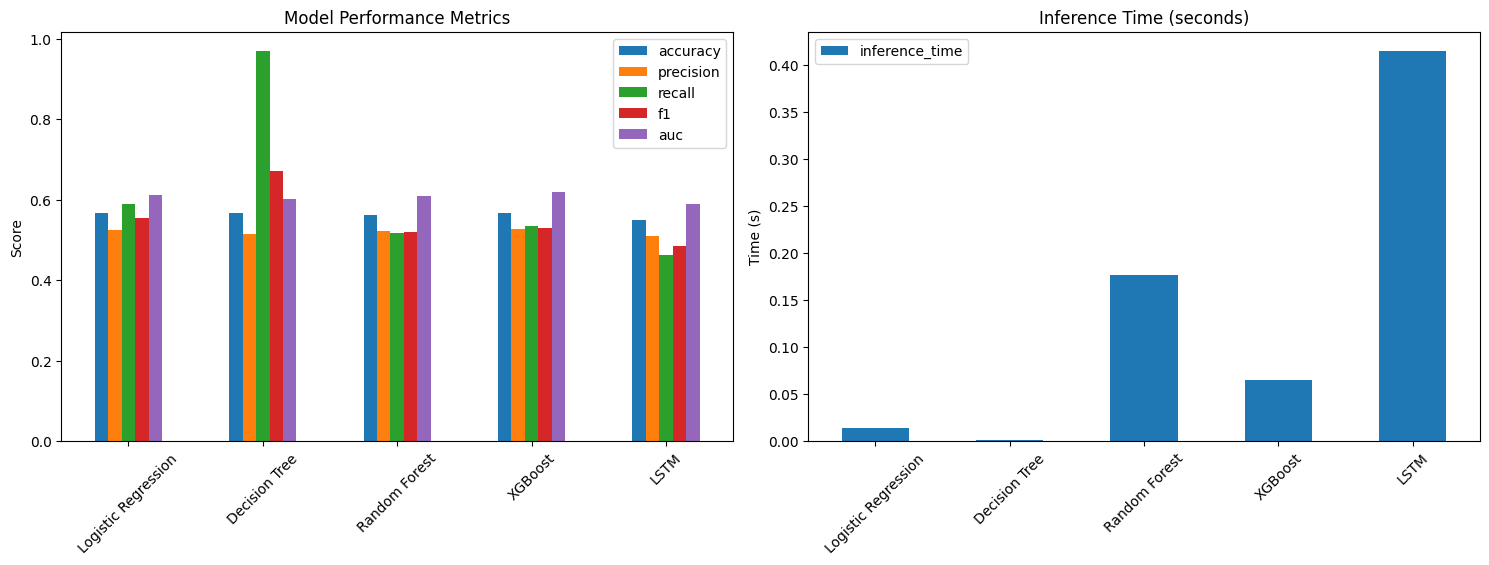

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, confusion_matrix,
                           roc_auc_score, RocCurveDisplay)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def evaluate_model(model, X_test, y_test, model_type='standard'):
    """
    Evaluate a pre-trained model on test data.

    Args:
        model: Pre-trained model object
        X_test: Test features (DataFrame)
        y_test: True labels
        model_type: 'standard', 'logistic', 'decision_tree', 'random_forest', 'xgboost', or 'lstm'

    Returns:
        Dictionary of metrics
        Array of predictions
    """
    start_time = time.time()

    # Define model-specific features
    base_features = ['rsi_14', 'daily_return', 'volumeto', 'vwap', 'coin_code']
    feature_map = {
        'logistic': base_features + ['macd_line', 'macd_signal'],
        'decision_tree': base_features + ['bb_upper', 'bb_lower', 'volume_zscore'],
        'random_forest': base_features + [f'return_lag_{lag}' for lag in [1, 3]] + ['macd_line'],
        'xgboost': base_features + [f'return_lag_{lag}' for lag in [1, 3, 7]] + ['bb_upper', 'bb_lower'],
        'lstm': ['close', 'volumeto', 'rsi_14', 'macd_line']
    }

    if model_type == 'lstm':
        # Load LSTM preprocessing components
        lstm_scaler = joblib.load('models/lstm_scaler.pkl')
        coin_encoder = joblib.load('models/coin_encoder.pkl')
        lstm_config = joblib.load('models/lstm_config.pkl')
        
        # Prepare LSTM input data
        coin_codes = coin_encoder.transform(X_test['coin'])
        X_num_scaled = lstm_scaler.transform(X_test[lstm_config['feature_columns']])
        
        # Create sequences
        def create_sequences(data, coin_data, seq_length):
            X_seq, X_coin = [], []
            for i in range(len(data) - seq_length):
                X_seq.append(data[i:i+seq_length])
                X_coin.append(coin_data[i:i+seq_length])
            return np.array(X_seq), np.array(X_coin)
        
        X_seq_test, X_coin_test = create_sequences(X_num_scaled, coin_codes, lstm_config['sequence_length'])
        
        # Make predictions
        y_proba = model.predict([X_seq_test, X_coin_test]).flatten()
        y_pred = (y_proba > 0.5).astype(int)
        
        # Align y_test with predictions
        y_test_aligned = y_test[lstm_config['sequence_length']:]
    else:
        # Use appropriate features for other models
        features = feature_map.get(model_type, X_test.columns)
        X_model = X_test[features]
        
        # Make predictions
        y_pred = model.predict(X_model)
        y_proba = model.predict_proba(X_model)[:, 1] if hasattr(model, 'predict_proba') else None
        y_test_aligned = y_test

    pred_time = time.time() - start_time

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test_aligned, y_pred),
        'precision': precision_score(y_test_aligned, y_pred),
        'recall': recall_score(y_test_aligned, y_pred),
        'f1': f1_score(y_test_aligned, y_pred),
        'inference_time': pred_time
    }

    if y_proba is not None:
        metrics['auc'] = roc_auc_score(y_test_aligned, y_proba)

    return metrics, y_pred
# Load pre-trained models
models = {
    'Logistic Regression': joblib.load('models/lr_model.pkl'),
    'Decision Tree': joblib.load('models/dt_model.pkl'),
    'Random Forest': joblib.load('models/rf_model.pkl'),
    'XGBoost': joblib.load('models/xgb_model.pkl'),
    'LSTM': load_model('models/lstm_model.h5')
}

# Initialize results storage
results = {}
predictions = {}

# Evaluate each model
for name, model in models.items():
    model_type = 'lstm' if name == 'LSTM' else name.lower().replace(' ', '_')
    metrics, y_pred = evaluate_model(model, X_test, y_test, model_type)
    results[name] = metrics
    predictions[name] = y_pred

# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
print("Model Comparison:")
print(comparison_df)

# Visualization
plt.figure(figsize=(15, 10))

# Metric Comparison
plt.subplot(2, 2, 1)
metric_cols = ['accuracy', 'precision', 'recall', 'f1', 'auc']
comparison_df[metric_cols].plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)

# Runtime Comparison
plt.subplot(2, 2, 2)
comparison_df[['inference_time']].plot(kind='bar', ax=plt.gca())
plt.title('Inference Time (seconds)')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

3
4
5
6
7


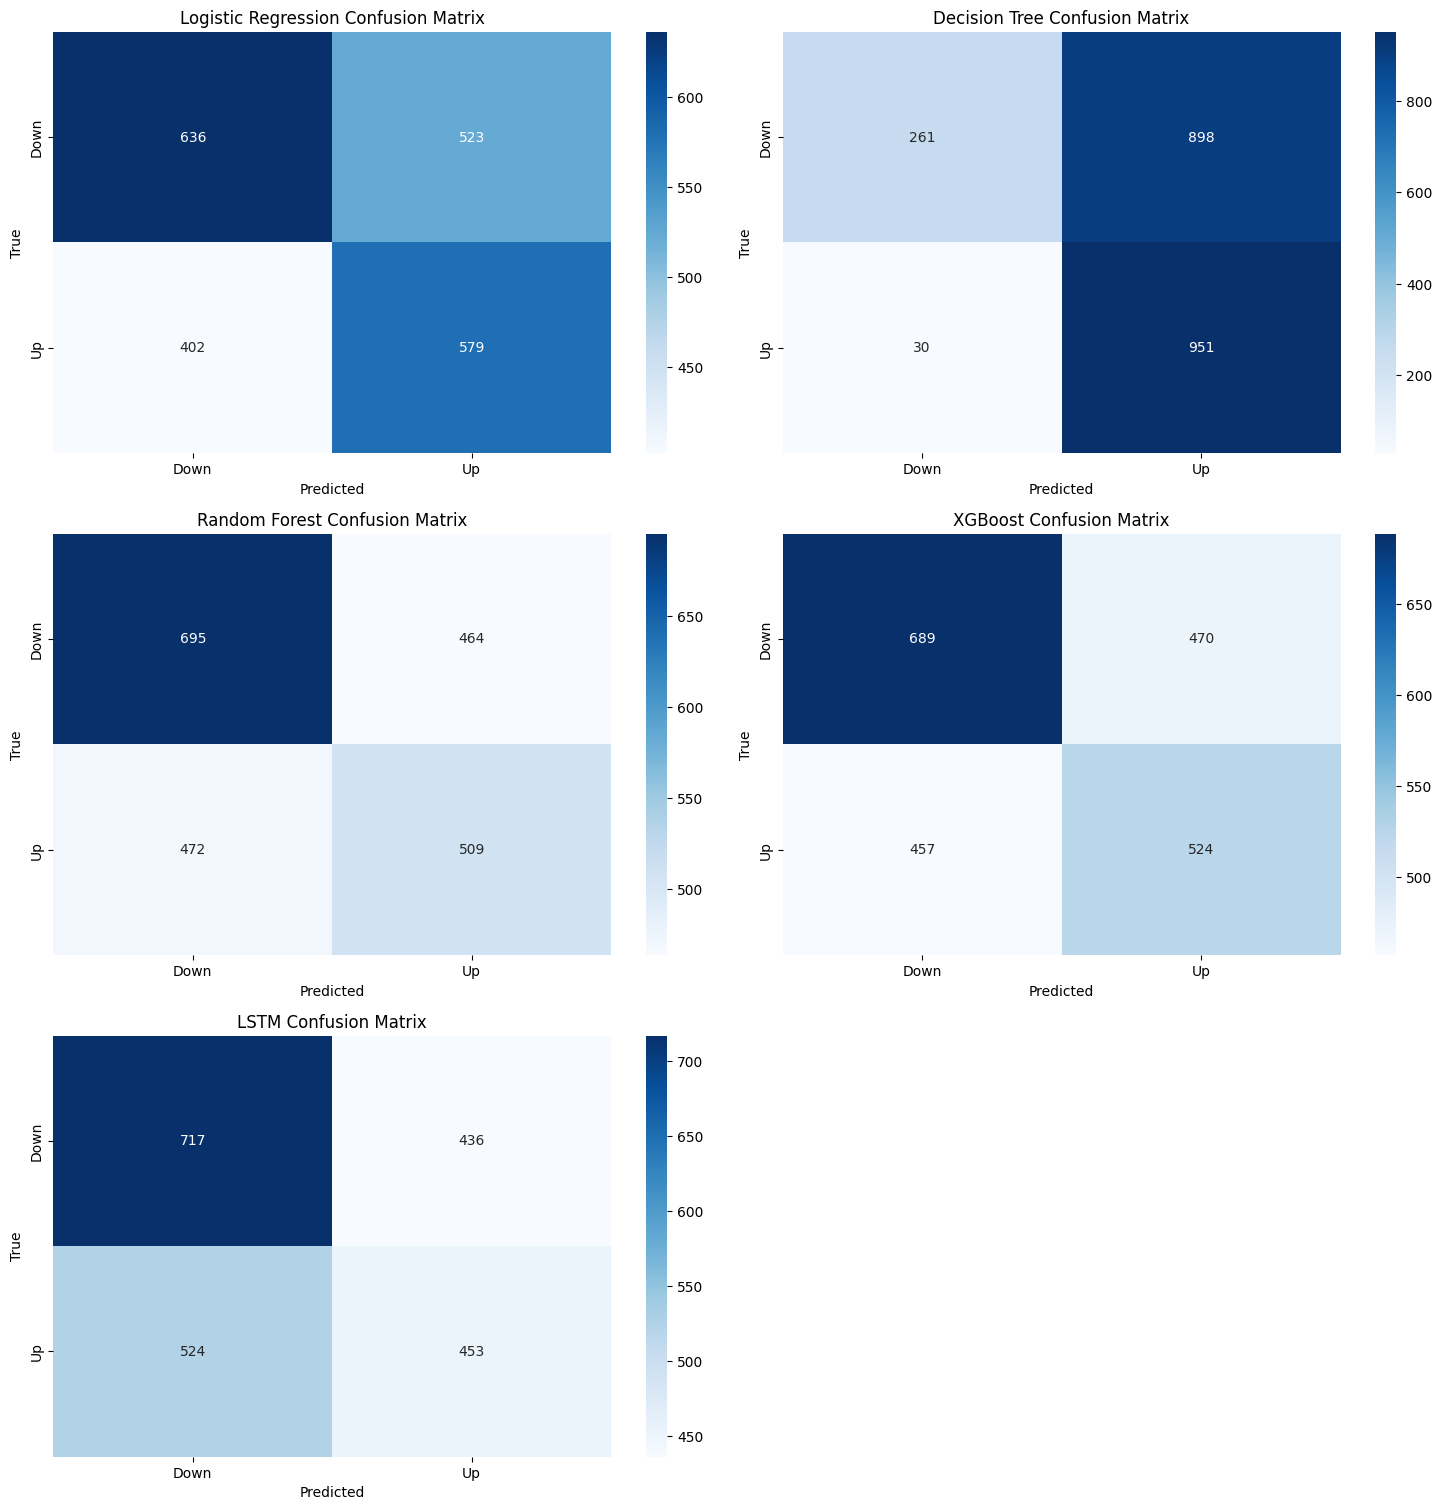

In [ ]:
# Visualization
num_models = len(predictions)
num_rows = (num_models + 3) // 2 
fig = plt.figure(figsize=(15, 5 * num_rows))

# Confusion Matrices
for i, (name, y_pred) in enumerate(predictions.items(), 3):
    plt.subplot(num_rows, 2, i)
    cm = confusion_matrix(y_test[len(y_test)-len(y_pred):], y_pred)  # Align with LSTM predictions
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Down', 'Up'], 
                yticklabels=['Down', 'Up'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
plt.tight_layout()
plt.show()

Actual Values:


,accuracy,precision,recall,f1,inference_time,auc
Logistic Regression,0.567757,0.525408,0.590214,0.555929,0.014317,0.613455
Decision Tree,0.566355,0.514332,0.969419,0.672085,0.001317,0.603529
Random Forest,0.562617,0.523124,0.518858,0.520983,0.176864,0.608688
XGBoost,0.566822,0.527163,0.534149,0.530633,0.065460,0.619227
LSTM,0.549296,0.509561,0.463664,0.485531,0.414203,0.589135



Normalized Values (0-1 range):


,accuracy,precision,recall,f1,inference_time,auc
Logistic Regression,9.999995e-01,9.003142e-01,2.502197e-01,3.773616e-01,0.968515,8.081646e-01
Decision Tree,9.240637e-01,2.710408e-01,1.000000e+00,9.999999e-01,1.000000,4.783316e-01
Random Forest,7.215684e-01,7.705544e-01,1.091320e-01,1.900362e-01,0.574830,6.497512e-01
XGBoost,9.493756e-01,9.999994e-01,1.393651e-01,2.417654e-01,0.844647,9.999997e-01
LSTM,5.416750e-07,5.681272e-07,1.977243e-08,5.360370e-08,0.000000,3.323112e-07


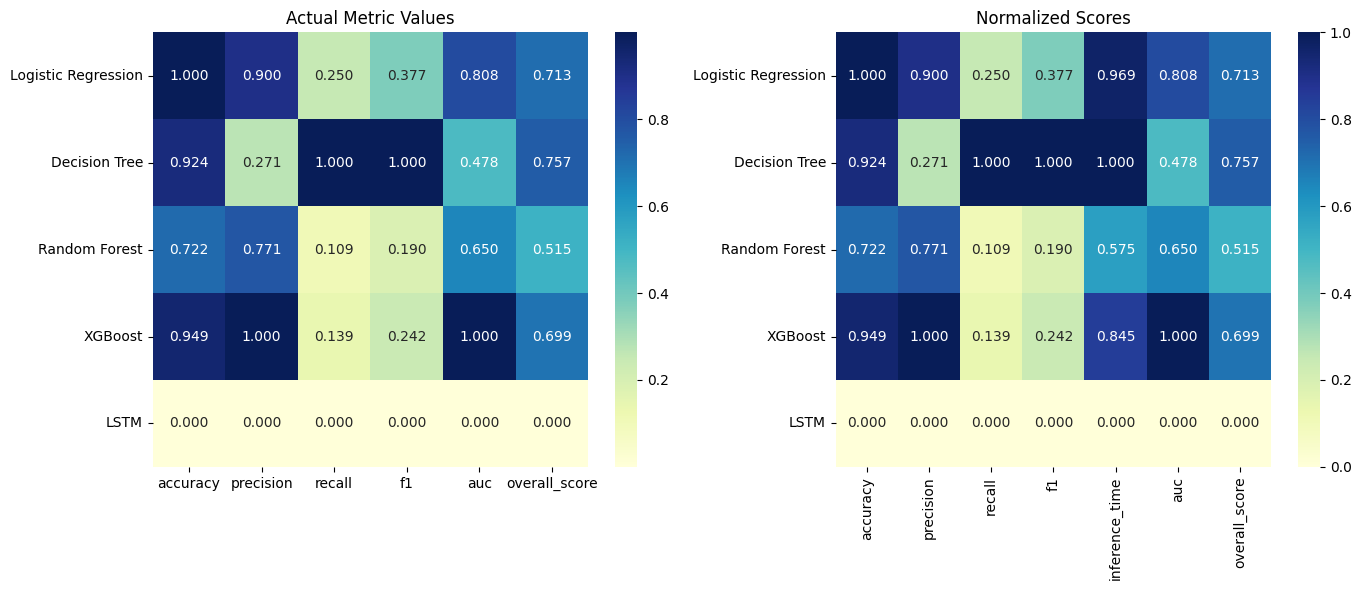


Models Ranked by Overall Score:


,overall_score
Decision Tree,7.569738e-01
Logistic Regression,7.127184e-01
XGBoost,6.988340e-01
Random Forest,5.150842e-01
LSTM,3.125775e-07


In [77]:
import numpy as np
epsilon = 1e-8

# Correct normalization function that handles zero-range cases
def safe_normalize(series):
    range_val = series.max() - series.min()
    if range_val > epsilon:
        return (series - series.min() + epsilon) / (range_val + 2*epsilon)
    else:
        return series * 0 + 0.5 

# Recalculate normalized metrics
normalized_df = comparison_df.copy()
for col in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    normalized_df[col] = safe_normalize(normalized_df[col])
    
# Special handling for inference time (lower is better)
time_range = normalized_df['inference_time'].max() - normalized_df['inference_time'].min()
if time_range > 0:
    normalized_df['inference_time'] = 1 - ((normalized_df['inference_time'] - normalized_df['inference_time'].min()) / time_range)
else:
    normalized_df['inference_time'] = 1  # All times identical

# Show the actual values vs normalized
print("Actual Values:")
display(comparison_df)
print("\nNormalized Values (0-1 range):")
display(normalized_df)

# Recalculate overall scores with proper weights
weights = {
    'accuracy': 0.25,
    'precision': 0.20, 
    'recall': 0.15,
    'f1': 0.20,
    'auc': 0.15,
    'inference_time': 0.05
}

normalized_df['overall_score'] = sum(normalized_df[col] * weight for col, weight in weights.items())

# Visual comparison
plt.figure(figsize=(14, 6))

# Actual metrics
plt.subplot(1, 2, 1)
df_plot = normalized_df.drop('inference_time', axis=1)
sns.heatmap(df_plot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Actual Metric Values")

# Normalized scores
plt.subplot(1, 2, 2)
sns.heatmap(normalized_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Normalized Scores")

plt.tight_layout()
plt.show()

# Final ranked comparison
print("\nModels Ranked by Overall Score:")
display(normalized_df.sort_values('overall_score', ascending=False)[['overall_score']])


=== Tuning DecisionTree ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best DecisionTree params: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'gini', 'ccp_alpha': 0.01}
Best validation F1: 0.5589

=== Tuning LogisticRegression ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/kartik/github/cryptocurrency_market_analysis/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kartik/github/cryptocurrency_market_analysis/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kartik/github/cryptocurrency_market_analysis/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kartik/github/cryptocurrency_market_analysis/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best LogisticRegression params: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 100.0}
Best validation F1: 0.6209

=== Tuning XGBoost ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost params: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best validation F1: 0.4719

=== Final Model Comparison ===


,Model,Accuracy,Precision,Recall,F1,AUC
0,DecisionTree,0.566355,0.514332,0.969419,0.672085,0.603529
1,LogisticRegression,0.458411,0.458411,1.000000,0.628645,0.593328
2,XGBoost,0.564486,0.526429,0.497452,0.511530,0.610939


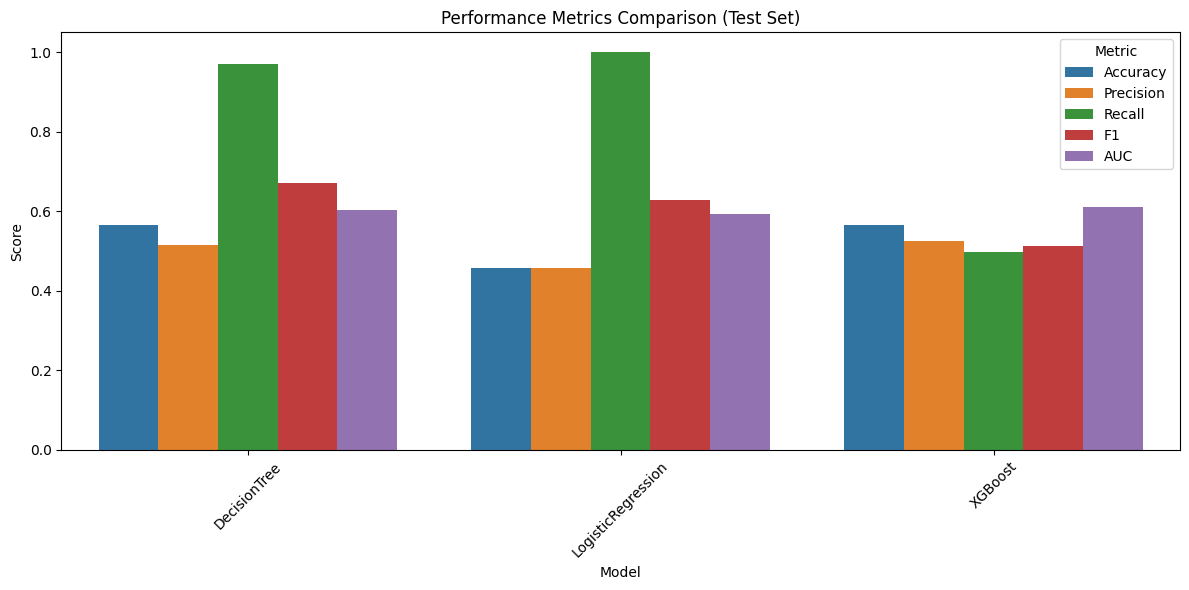


 Best Model for Deployment: DecisionTree with F1-score 0.6721


['production_model.pkl']

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import make_scorer, f1_score


##  Best Model Candidates
# Based on your results, these are the top 3 models
best_model_candidates = {
    'DecisionTree': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier()
}

##  Define Hyperparameter Grids
param_grids = {
    'DecisionTree': {
        'max_depth': [3, 5, 7, 9, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy'],
        'ccp_alpha': [0.0, 0.01, 0.1]  # For pruning
    },
    'LogisticRegression': {
        'C': np.logspace(-3, 3, 7),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 200, 300],
        'gamma': [0, 0.1, 0.2]
    }
}

## Feature Sets for Each Model
feature_sets = {
    'DecisionTree': ['rsi_14', 'daily_return', 'volumeto', 'vwap', 'coin_code', 
                    'bb_upper', 'bb_lower', 'volume_zscore'],
    'LogisticRegression': ['rsi_14', 'daily_return', 'volumeto', 'vwap', 'coin_code',
                         'macd_line', 'macd_signal'],
    'XGBoost': ['rsi_14', 'daily_return', 'volumeto', 'vwap', 'coin_code'] +
               [f'return_lag_{lag}' for lag in [1, 3, 7]] + ['bb_upper', 'bb_lower']
}

## Perform Tuning for Each Model
best_models = {}
results = []

for model_name in best_model_candidates:
    print(f"\n=== Tuning {model_name} ===")
    
    # Select features
    features = feature_sets[model_name]
    X_train_subset = X_train[features]
    
    # Use F1 score as primary metric
    scorer = make_scorer(f1_score)
    
    # Use RandomizedSearch for faster tuning (switch to GridSearch for exhaustive search)
    search = RandomizedSearchCV(
        estimator=best_model_candidates[model_name],
        param_distributions=param_grids[model_name],
        n_iter=20,  # Increase for better results
        scoring=scorer,
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(X_train_subset, y_train)
    
    # Store results
    best_models[model_name] = search.best_estimator_
    results.append({
        'Model': model_name,
        'Best Score': search.best_score_,
        'Best Params': search.best_params_
    })
    
    # Save best model
    joblib.dump(search.best_estimator_, f'best_{model_name.lower()}_model.pkl')
    
    print(f"Best {model_name} params: {search.best_params_}")
    print(f"Best validation F1: {search.best_score_:.4f}")

## Evaluate Best Models on Test Set
final_results = []

for model_name, model in best_models.items():
    features = feature_sets[model_name]
    X_test_subset = X_test[features]
    
    y_pred = model.predict(X_test_subset)
    y_proba = model.predict_proba(X_test_subset)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    
    final_results.append(metrics)

## Display Final Comparison
final_df = pd.DataFrame(final_results)
print("\n=== Final Model Comparison ===")
display(final_df.sort_values('F1', ascending=False))

## Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=final_df.melt(id_vars='Model', var_name='Metric'), 
            x='Model', y='value', hue='Metric')
plt.title('Performance Metrics Comparison (Test Set)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Select Best Model for Deployment
best_model_name = final_df.loc[final_df['F1'].idxmax(), 'Model']
best_model = best_models[best_model_name]
print(f"\n Best Model for Deployment: {best_model_name} with F1-score {final_df['F1'].max():.4f}")

# Save the best model
joblib.dump(best_model, 'production_model.pkl')